In [1]:
import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import time
import itertools
import statsmodels.api as sm
import numpy.ma as ma
from scipy.stats.stats import pearsonr, normaltest
from scipy.spatial.distance import correlation
os.getcwd()
os.chdir(r'C:\Users\Haneef Usmani\Desktop\STAT 303-2\Project')

In [2]:
import pandas as pd
from datetime import datetime
airports = pd.read_csv('airports.csv')
airports.columns = airports.columns.str.lower()
airports.head()
flights = pd.read_csv('flights.csv')
flights.columns = flights.columns.str.lower()

flights = flights.merge(right=airports, how='left', left_on='origin_airport', right_on='iata_code')
flights.rename(columns={'latitude': 'origin_latitude', 'longitude': 'origin_longitude'}, inplace=True)

flights = flights.merge(right=airports, 
                        how='left', left_on='destination_airport', right_on='iata_code',
                        suffixes=('_origin', '_destination'))
flights.head()
flights_clean = flights[flights.columns.difference([
    'year', # all are 2015
    'flight_number', # irrelevant
    'tail_number', # irrelevant
    'departure_time', # collinearity: scheduled_departure + departure_delay
    'wheels_off', # co: departure_time + taxi_out
    'elapsed_time', # co: scheduled_time + departure_delay
    'air_time', # co: elapsed_time - taxi_out - taxi_in
    'wheels_on', # co: arrival_time - taxi_in
    'arrival_time', # co: scheduled_arrival
    # leave in scheduled_arrival because of time change
    'arrival_delay', # co: departure_delay
    'diverted', # occurs after delay, can't be used to predict delay time
    'cancelled', # occurs after delay
    'cancellation_reason',
    'air_system_delay',
    'security_delay',
    'airline_delay',
    'late_aircraft_delay',
    'weather_delay',
    'iata_code_origin', 'iata_code_destination', # same as origin_airport
    'airport_origin', 'airport_destination', # airport already described in origin_airport
    'country_origin', 'country_destination' # all are USA
])]
def time_to_minutes(n):
    # converts from HHMM time (written as number)
    # to number of minutes elapsed since midnight
    return (n // 100) * 60 + (n % 100)
flights_clean.scheduled_departure = flights_clean.scheduled_departure.apply(time_to_minutes)
flights_clean.scheduled_arrival = flights_clean.scheduled_arrival.apply(time_to_minutes)
def day_counter(row):
    # convert from month and day to nth day of year (i.e. feb 1 -> 32)
    return (datetime(year=2015, month=row.month, day=row.day) - datetime(year=2014, month=12, day=31)).days
flights_clean['day_of_year'] = flights_clean.apply(day_counter, axis=1)
flights_clean.head()
flights_clean.loc[0]
flights_clean.dtypes
flights_clean.to_csv('flights_clean.csv', index=False)

C:\Users\Haneef Usmani\AppData\Local\Temp\ipykernel_10980\2562572326.py:6: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  flights = pd.read_csv('flights.csv')
C:\Users\Haneef Usmani\AppData\Local\Temp\ipykernel_10980\2562572326.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_clean.scheduled_departure = flights_clean.scheduled_departure.apply(time_to_minutes)
C:\Users\Haneef Usmani\AppData\Local\Temp\ipykernel_10980\2562572326.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [5]:
flights_clean.columns

Index(['airline', 'city_destination', 'city_origin', 'day', 'day_of_week',
       'departure_delay', 'destination_airport', 'distance', 'latitude',
       'longitude', 'month', 'origin_airport', 'origin_latitude',
       'origin_longitude', 'scheduled_arrival', 'scheduled_departure',
       'scheduled_time', 'state_destination', 'state_origin', 'taxi_in',
       'taxi_out', 'day_of_year'],
      dtype='object')

In [6]:
# variables most corrleated with departure delay
flights_clean.corr().departure_delay.sort_values(ascending=False)

departure_delay        1.000000
scheduled_departure    0.110211
scheduled_arrival      0.097523
taxi_out               0.058515
origin_longitude       0.031857
scheduled_time         0.027799
longitude              0.025585
distance               0.024106
taxi_in                0.012784
latitude               0.002190
day                   -0.000176
origin_latitude       -0.003755
day_of_week           -0.011510
day_of_year           -0.021968
month                 -0.021994
Name: departure_delay, dtype: float64

In [8]:
model = smf.ols(formula='departure_delay ~ scheduled_departure + scheduled_arrival + taxi_out', data=flights_clean).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        departure_delay   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                 3.145e+04
Date:                Wed, 01 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:25:07   Log-Likelihood:            -2.8774e+07
No. Observations:             5730032   AIC:                         5.755e+07
Df Residuals:                 5730028   BIC:                         5.755e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -7.1776      0.057   -125.766      0.000      -7.289      -7.066
scheduled_departure     0.0106   7.44e-05    143.207      0.000       0.011       0.011
scheduled_arrival       0.0045   7.11e-05     63.589      0.000       0.004       0.005
taxi_out                0.2373      0.002    137.665      0.000       0.234       0.241
==============================================================================
Omnibus:                  7834411.954   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3900725472.306
Skew:                           7.694   Prob(JB):                         0.00
Kurtosis:                     129.891   Cond. No.                     4.75e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
# create a subset of flights_clean with all columns except departure_delay
flights_clean_subset = flights_clean[flights_clean.columns.difference(['departure_delay'])]
flights_clean_subset.head()

,airline,city_destination,city_origin,day,day_of_week,day_of_year,destination_airport,distance,latitude,longitude,...,origin_airport,origin_latitude,origin_longitude,scheduled_arrival,scheduled_departure,scheduled_time,state_destination,state_origin,taxi_in,taxi_out
0,AS,Seattle,Anchorage,1,4,1,SEA,1448,47.44898,-122.30931,...,ANC,61.17432,-149.99619,270,5,205.0,WA,AK,4.0,21.0
1,AA,West Palm Beach,Los Angeles,1,4,1,PBI,2330,26.68316,-80.09559,...,LAX,33.94254,-118.40807,470,10,280.0,FL,CA,4.0,12.0
2,US,Charlotte,San Francisco,1,4,1,CLT,2296,35.21401,-80.94313,...,SFO,37.61900,-122.37484,486,20,286.0,NC,CA,11.0,16.0
3,AA,Miami,Los Angeles,1,4,1,MIA,2342,25.79325,-80.29056,...,LAX,33.94254,-118.40807,485,20,285.0,FL,CA,8.0,15.0
4,AS,Anchorage,Seattle,1,4,1,ANC,1448,61.17432,-149.99619,...,SEA,47.44898,-122.30931,200,25,235.0,AK,WA,5.0,11.0


In [13]:
# perform forward stepwise selection on the model to predict departure_delay using the dataset X
# X is a pandas dataframe
# y is a pandas series
# returns a list of the selected features
def forward_selection(X, y):
    selected_features = []
    while True:
        remaining_features = list(set(X.columns) - set(selected_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = smf.ols(formula='departure_delay ~ ' + '+'.join(selected_features + [new_column]), data=flights).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if min_p_value < 0.05:
            best_feature = new_pval.idxmin()
            selected_features.append(best_feature)
        else:
            break
    return selected_features



In [16]:
#add the departure_delay column to the end of X
X['departure_delay'] = y

C:\Users\Haneef Usmani\AppData\Local\Temp\ipykernel_12048\2616848850.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['departure_delay'] = y


In [10]:
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = smf.ols('np.log(departure_delay)~' + '+'.join(predictor_subset),data = flights_clean).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(flights_clean_subset.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [11]:
# #Function to select the best model amongst the best models for 'k' predictors, where k = 1,2,3,..
models_best = pd.DataFrame(columns=["Rsquared", "model"])

tic = time.time()
for i in range(1,1+flights_clean_subset.shape[1]):
    models_best.loc[i] = getBest_model(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

c:\Users\Haneef Usmani\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Haneef Usmani\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Haneef Usmani\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1687: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)
c:\Users\Haneef Usmani\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Haneef Usmani\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


NameError: name 'models_best' is not defined

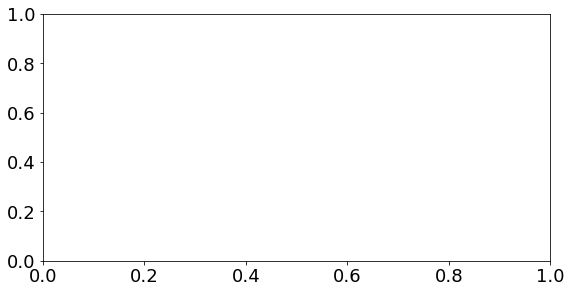

In [19]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()